In [38]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10


# import seaborn as sns

# import pandas as pd
# import numpy as np

# from nltk.corpus import wordnet as wn
# from nltk import word_tokenize, pos_tag
# from nltk.corpus import stopwords
# stops = set(stopwords.words('english'))

# from sklearn.feature_extraction.text import TfidfVectorizer

# import re

# import spacy
# # Load spaCy pipeline. Disable Named Entity Recognition, since I don't need it. 

# nlp = spacy.load('en_core_web_lg', disable=['ner'])


## Sentence Average WordNet Distance

[This paper]((https://www.aaai.org/Papers/AAAI/2006/AAAI06-123.pdf) describes a method for scoring the sematic difference of sentences using WordNet. 

The idea is a scoring scheme which looks at the average "distance" of the words in the two sentences.

To calculate the distance between sentences $T_1$ and $T_2$, go through the words in $T_1$ and find the word which is "closest" to it in $T_2$. Average these distances across all the words in $T_1$. 

To get a symmetric scoring scheme (i.e $Similiarity(T_1,T_2) = Similarity(T_2,T_1)$, perform the same operation, but this time starting with $T_2$ and findint the most similar words in $T_1$ to each word. The paper also suggests the use of _IDF_ scores.

The score can be summarized: (Mihalcea, Corley, Strapparava)

$$
Similarity(T_1,T_2) = \frac{1}{2}( \frac{\sum_{w \in T_1}MaxSimilarity(w, T_2)idf(w)}{\sum_{w \in T_1}idf(w)}
+ \frac{\sum_{w \in T_2}MaxSimilarity(w, T_1)idf(w)}{\sum_{w \in T_2}idf(w)})
$$

Where $Similarity(w, T_i)$ is the greatest similarity between a word $w$ and word in $T_i$, according to some similarity metric (with respect to WordNet). This is a heuristic for getting the semantic similarity of sentences. 

Note: word comparisons are limited to words of the same part of speech. Furthermore, each word is always assumed to be the most common sense of that word. 

As a start, I'll implement this idea without _IDF_ scores, using a variety of WordNet distance metrics. If time permits, I'll include Idf scores as well. 

**Note**: Much of this code is taken from [this great blog post!](http://nlpforhackers.io/wordnet-sentence-similarity/)

### 0. Load data to experiment with

In [2]:
data = pd.read_csv("../data/features.csv")

In [3]:
data_sample = data.sample(100)

In [4]:
data.head()

,Unnamed: 0,Unnamed: 0.1,id,qid1,qid2,question1,question2,is_duplicate,len_intersection,len_intersection_sw,...,q2_max_tf_idf_embedding,euclidean_distance_max_tfidf_word,cosine_distance_max_tfidf_word,path_similarity,path_similarity_idf,lch_similarity_idf,wup_similarity_idf,embedding_similarity_score_idf,lch_similarity,wup_similarity
0,0,1,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10,5,...,[-0.028461 -0.34314999 0.23021001 -0.063865...,0.000000,3.250036e-08,0.933333,0.929129,3.348972,0.933559,0.951548,3.326693,0.937500
1,1,2,1,3,4,What is the story of Kohinoor Koh - i - Noor D...,What would happen if the Indian government sto...,0,2,0,...,[ 3.72870006e-02 -3.17849994e-01 -2.3973000...,0.000000,4.103800e-08,0.582143,0.534293,2.575241,0.666331,0.581344,2.690605,0.702500
2,2,3,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,3,2,...,[ -4.19200003e-01 5.06489992e-01 -3.4162998...,5.495713,4.284846e-01,0.574359,0.580354,2.551049,0.689253,0.772741,2.544828,0.680357
3,3,4,3,7,8,Why am I mentally very lonely ? How can I solv...,Find the remainder when math 23 24 math is div...,0,0,0,...,[-0.39732999 -0.13798 0.21100999 0.237990...,4.781672,8.190252e-01,0.612500,0.458929,2.206308,0.556602,0.381349,2.509163,0.683333
4,4,5,4,9,10,"Which one dissolve in water quickly sugar , sa...",Which fish would survive in salt water ?,0,3,2,...,[-0.064408 -0.073121 -0.25946999 0.15424 ...,6.219034,8.441631e-01,0.554004,0.518265,2.391333,0.653720,0.628441,2.481718,0.670232


#### 0.1 Fixing the error in the `cosine_distance_max_tfidf_word` feature

When creating this feature, I forgot to account for a division by zero error. I've been pushing off fixing this issue, as writing this file takes a while. I'll do it now. 

In [5]:
# quick fix - fixed on the features notebook but did not re-save data yet

fill = data[pd.isnull(data['cosine_distance_max_tfidf_word'])].apply(lambda x: 0 if
                        np.array_equal(x['q1_max_tf_idf_embedding'], x['q2_max_tf_idf_embedding'])  
                        else 1, axis = 1)

data['cosine_distance_max_tfidf_word'] = data['cosine_distance_max_tfidf_word'].fillna(fill)

In [6]:

fill = data[pd.isnull(data['cosine_distance_sentence_embeddings'])].apply(lambda x: 0 if
                        np.array_equal(x['q1_embedding'], x['q2_embedding'])  
                        else 1, axis = 1)

if len(fill) > 0:
    data['cosine_distance_sentence_embeddings'] = data['cosine_distance_sentence_embeddings'].fillna(fill)

### 1. Simple POS tagging

In the proposed algorithm, we should only compare words of the same POS category (nouns, verbs, adjectives or adverbs). 

Below is a function which produces these broad tags for tokenized words

#### 1.0 Conert Penn POS tags to broad tags

`pos_tag` by NLTK automatcially gives fine POS tags. Example

In [14]:
pos_tag(word_tokenize("this is a pretty sentence"))

[('this', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('pretty', 'JJ'),
 ('sentence', 'NN')]

This function brings them to more simple POS tags (courtesy of [bogdani](http://nlpforhackers.io/author/bogdani/))

In [14]:
def penn_to_wn(tag):
    """ Convert between a Penn Treebank tag to a simplified Wordnet tag """
    if tag.startswith('N'):
        return 'n'
 
    if tag.startswith('V'):
        return 'v'
 
    if tag.startswith('J'):
        return 'a'
 
    if tag.startswith('R'):
        return 'r'
 
    return None

In [13]:
# test conversion
[(word, penn_to_wn(tag)) for (word,tag) in pos_tag(word_tokenize("this is a pretty sentence."))]

[('this', None),
 ('is', 'v'),
 ('a', None),
 ('pretty', 'a'),
 ('sentence', 'n'),
 ('.', None)]

Notice: only nounds, verbs, adjectives and adverbs are tagged. Here, the determiners and punctuations are tagged as `None`. 

### 2. Get synsets

Now we can get the synset of the most common sense of word, filtered by part of speech (again courtesy of [bogdani](http://nlpforhackers.io/author/bogdani/))

In [15]:
# get the most common synset for a tagged word from WordNet. 
def tagged_to_synset(word, tag):
    wn_tag = penn_to_wn(tag)
    if wn_tag is None:
        return None
    try:
        # get the first synset of the word in WordNet
        return wn.synsets(word, wn_tag)[0]
    except:
        return None

In [24]:
# example
ex = pos_tag(word_tokenize("this is a pretty sentence."))
ex

[('this', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('pretty', 'JJ'),
 ('sentence', 'NN'),
 ('.', '.')]

In [25]:
[tagged_to_synset(word,tag) for (word,tag) in ex]

[None,
 Synset('be.v.01'),
 None,
 Synset('pretty.s.01'),
 Synset('sentence.n.01'),
 None]

### 3. Sentence similarities

Now, I'll define series of functions for finding the sentence similarity scores for pairs of sentences, using a variety of wordnet distance metrics. 



#### 3.0 Path similarity

This score is the distance betweeen synsets in WordNet - through the hyponym/hypernym path

In [68]:
 pos_tag(word_tokenize("this is a word"))

[('this', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('word', 'NN')]

In [16]:
def path_similarity(sentence1, sentence2):
    """ compute the sentence similarity using Wordnet """
    # Tokenize and tag
    sentence1 = pos_tag(word_tokenize(sentence1))
    sentence2 = pos_tag(word_tokenize(sentence2))
 
    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]
    
    # Zip up the synsets and the words/POS tags
    zipped1 = zip(sentence1,synsets1)
    zipped2 = zip(sentence2,synsets2)
    
    # filter out the Nones
    zipped1 = [z for z in zipped1 if z[1] is not None]
    zipped2 = [z for z in zipped2 if z[1] is not None]
 
 
    score1, count1, score2, count2 = 0.0, 0, 0.0, 0 
 
    # For each word in the first sentence
    for tup1 in zipped1:
        try:
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([tup1[1].path_similarity(ss[1]) for ss in zipped2 if \
                              penn_to_wn(ss[0][1]) == penn_to_wn(tup1[0][1])])
        except:
            best_score = None
 
        # Check that the similarity could have been computed
        if best_score is not None:
            score1 += best_score
            count1 += 1
            
    for tup2 in zipped2:
        try:
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([tup2[1].path_similarity(ss[1]) for ss in zipped1 if \
                              penn_to_wn(ss[0][1]) == penn_to_wn(tup2[0][1])])
        except:
            best_score = None
        # Check that the similarity could have been computed
        if best_score is not None:
            score2 += best_score
            count2 += 1
 
    try:
        # Average the values and add score from both sides to get symmetic distance
        score = .5*(score1/count1 + score2/count2)
        return(score)
    except:
        return(None)

In [370]:
path_similarity("The Mona-Lisa is pretty overrated if you ask me", \
                      "I hope that it will not rain tomorrow")

0.20575396825396824

In [371]:
path_similarity("Cats are beautiful animals.", "Dogs are awesome creatures")

0.7555555555555555

In [372]:
path_similarity("Trump reverses ban on importing remains of African elephants killed as trophies", \
                      "Native American tribe bracing for Keystone pipeline leak impact")

0.12751702662416947

#### 3.1 Leacock-Chodorow Similarity

This similarity score is similar to the path similarity, but also incorporates the depth of the word in the WordNet taxonomy. The deeper the taxonomy depth, the higher the similarity score.

The intuition is that the deeper the word are in the tree, the longer the paths between them in genereal. The second factor counters this fact. 

In [17]:
def lch_similarity(sentence1, sentence2):
    """ compute the sentence similarity using Wordnet """
    # Tokenize and tag
    sentence1 = pos_tag(word_tokenize(sentence1))
    sentence2 = pos_tag(word_tokenize(sentence2))
 
    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]
    
    # Zip up the synsets and the words/POS tags
    zipped1 = zip(sentence1,synsets1)
    zipped2 = zip(sentence2,synsets2)
    
    # filter out the Nones
    zipped1 = [z for z in zipped1 if z[1] is not None]
    zipped2 = [z for z in zipped2 if z[1] is not None]
    
    score1, count1, score2, count2 = 0.0, 0, 0.0, 0 
    
    # For each word in the first sentence
    for tup1 in zipped1:
        try:
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([tup1[1].lch_similarity(ss[1]) for ss in zipped2 if \
                              penn_to_wn(ss[0][1]) == penn_to_wn(tup1[0][1])])
        except:
            best_score = None
        # Check that the similarity could have been computed
        if best_score is not None:
            score1 += best_score
            count1 += 1
            
    for tup2 in zipped2:
        try:
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([tup2[1].lch_similarity(ss[1]) for ss in zipped1 if \
                              penn_to_wn(ss[0][1]) == penn_to_wn(tup2[0][1])])
        except:
            best_score = None
            
        # Check that the similarity could have been computed
        if best_score is not None:
            score2 += best_score
            count2 += 1
 
    try:
        # Average the values and add score from both sides to get symmetic distance
        score = .5*(score1/count1 + score2/count2)
        return(score)
    except:
        return(None)

In [374]:
lch_similarity("Trump reverses ban on importing remains of African elephants killed as trophies", \
                      "Native American tribe bracing for Keystone pipeline leak impact")

1.42868502671942

In [396]:
lch_similarity(data.ix[221]['question1'], data.ix[221]['question2'])

#### 3.2 Wu-Palmer Similarity

This similarity score is "based on the depth of the two senses in the taxonomy and that of their Least Common Subsumer (most specific ancestor node)."

In [18]:
def wup_similarity(sentence1, sentence2):
    """ compute the sentence similarity using Wordnet """
    # Tokenize and tag
    sentence1 = pos_tag(word_tokenize(sentence1))
    sentence2 = pos_tag(word_tokenize(sentence2))
 
    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]
    
    # Zip up the synsets and the words/POS tags
    zipped1 = zip(sentence1,synsets1)
    zipped2 = zip(sentence2,synsets2)
    
    # filter out the Nones
    zipped1 = [z for z in zipped1 if z[1] is not None]
    zipped2 = [z for z in zipped2 if z[1] is not None]
 
    score1, count1, score2, count2 = 0.0, 0, 0.0, 0 
 
    # For each word in the first sentence
    for tup1 in zipped1:
        try:
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([tup1[1].wup_similarity(ss[1]) for ss in zipped2 if \
                              penn_to_wn(ss[0][1]) == penn_to_wn(tup1[0][1])])
        except:
            best_score = None
 
        # Check that the similarity could have been computed
        if best_score is not None:
            score1 += best_score
            count1 += 1
            
    for tup2 in zipped2:
        try:
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([tup2[1].wup_similarity(ss[1]) for ss in zipped1 if \
                              penn_to_wn(ss[0][1]) == penn_to_wn(tup2[0][1])])
        except:
            best_score = None
 
        # Check that the similarity could have been computed
        if best_score is not None:
            score2 += best_score
            count2 += 1
 
    # Average the values and add score from both sides to get symmetic distance
    try:
        score = .5*(score1/count1 + score2/count2)
        return(score)
    except:
        return(None)

In [376]:
wup_similarity("Cats are beautiful animals.", "Dogs are awesome creatures")

0.9553571428571429

In [222]:
wup_similarity("The Mona-Lisa is pretty overrated if you ask me", \
                      "I hope that it will not rain tomorrow")

0.3392857142857143

In [223]:
wup_similarity("Trump reverses ban on importing remains of African elephants killed as trophies", \
                      "Native American tribe bracing for Keystone pipeline leak impact")

0.3534215959110917

In [224]:
wup_similarity("I like to study in the montreal area with my friends", \
                      "I like to study in New York with my buddies")

0.7467086834733894

---

### 4. Including Idf scores

In the original paper, the similarity score was designed to incorporate Idf scores:

$$
Similarity(T_1,T_2) = \frac{1}{2}( \frac{\sum_{w \in T_1}MaxSimilarity(w, T_2)idf(w)}{\sum_{w \in T_1}idf(w)}
+ \frac{\sum_{w \in T_2}MaxSimilarity(w, T_1)idf(w)}{\sum_{w \in T_2}idf(w)})
$$

So far I've only implemented a simplifaction of this model, without Idf scores:

$$
Similarity(T_1,T_2) = \frac{1}{2}(\frac{( \sum_{w \in T_1}MaxSimilarity(w, T_2)}{|T_1|} + 
\frac{\sum_{w \in T_2}MaxSimilarity(w, T_1))}{|T_2|})
$$

Now, I'll calculate Idf scores, and re-implement these similarity scores to adhere to the original paper. 

#### 4.0 Calculating Idf Scores

To calculate Idf scores, I need the document frequency of each word.

To do this, I'll use Sklearns `TfidfVectorizer`, and extract the Idf dictionary fit by this model. 

In [20]:
# get all the corpus in one numpy array
values = data['question1'].append(data['question2']).apply(lambda x: re.sub('[ ]{2,}', ' ', re.sub('[^a-z]', ' ', x.strip()))
                                                      ).values
# train tf-idf weights to the training quesitons
vectorizer = TfidfVectorizer(lowercase = True)
vectorizer.fit(values)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [21]:
# store a dictionary of Idf weights. 
vectorizer.idf_
idf_dict =  dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

#### 4.1 Redefining the distance score functions to include Idf weights

In [22]:
def path_similarity_idf(sentence1, sentence2, idf_dict = idf_dict):
    """ compute the sentence path similarity using Wordnet.
    Incude IDF scores
    """
    # Tokenize and tag
    sentence1 = pos_tag(word_tokenize(sentence1))
    sentence2 = pos_tag(word_tokenize(sentence2))
 
    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]
    
    # Zip up the synsets and the words/POS tags
    zipped1 = zip(sentence1,synsets1)
    zipped2 = zip(sentence2,synsets2)
    
    # filter out the Nones
    zipped1 = [z for z in zipped1 if z[1] is not None]
    zipped2 = [z for z in zipped2 if z[1] is not None]
    

    score1, score2, idf_sum1, idf_sum2 = 0.0, 0.0, 0.0, 0.0
 
    # For each word in the first sentence
    for tup1 in zipped1:
        try:

            # isolate the synset object
            synset1 = tup1[1]
            # isolate the part of speech 
            synset1_pos = tup1[0][1]
            # isolate the word. lowercase so that can be found in IDF dictionary.
            word1 = tup1[0][0].lower()
            # isolate the idf score
            idf1 = idf_dict[word1]
            
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([synset1.path_similarity(ss[1]) for \
                              ss in zipped2 if penn_to_wn(ss[0][1]) == penn_to_wn(synset1_pos)])
        except Exception as e:
            best_score = None
            idf1 = None
 
        # Check that the similarity could have been computed. 
        # This means that the word was found in WordNet and in the IDF score dictionary.
        if best_score is not None and idf1 is not None:
            score1 += best_score*idf1
            idf_sum1 += idf1
            
    for tup2 in zipped2:
        try:
            # isolate the synset object
            synset2 = tup2[1]
            # isolate the part of speech 
            synset2_pos = tup2[0][1]
            # isolate the word. lowercase so that can be found in IDF dictionary.
            word2 = tup2[0][0].lower()            # isolate the idf score
            idf2 = idf_dict[word2]

            # Get the similarity value of the most similar word in the other sentence
            best_score = max([synset2.path_similarity(ss[1]) for ss in zipped1 if \
                              penn_to_wn(ss[0][1]) == penn_to_wn(synset2_pos)])
            
        except:
            best_score = None
            idf2 = None
        # Check that the similarity could have been computed
        if best_score is not None and idf2 is not None:
            score2 += best_score*idf2
            idf_sum2 += idf2

 
    try:
        # Average the values and add score from both sides to get symmetic distance
        score = .5*(score1/(idf_sum1) + score2/(idf_sum2))
        return(score)
    except:
        return(None)

In [378]:
path_similarity("The Mona-Lisa is pretty overrated if you ask me", \
                      "I hope that it will not rain tomorrow")

0.20575396825396824

In [379]:
path_similarity_idf("The Mona-Lisa is pretty overrated if you ask me", \
                      "I hope that it will not rain tomorrow")

0.197041524099238

In [228]:
path_similarity("Cats are beautiful animals.", "Dogs are awesome creatures")

0.7555555555555555

In [23]:
def lch_similarity_idf(sentence1, sentence2, idf_dict = idf_dict):
    """ 
    compute the sentence Leacock-Chodorow similarity using Wordnet.
    Incude IDF scores.
    """
    # Tokenize and tag
    sentence1 = pos_tag(word_tokenize(sentence1))
    sentence2 = pos_tag(word_tokenize(sentence2))
 
    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]
    
    # Zip up the synsets and the words/POS tags
    zipped1 = zip(sentence1,synsets1)
    zipped2 = zip(sentence2,synsets2)
    
    # filter out the Nones
    zipped1 = [z for z in zipped1 if z[1] is not None]
    zipped2 = [z for z in zipped2 if z[1] is not None]
    

    score1, score2, idf_sum1, idf_sum2 = 0.0, 0.0, 0.0, 0.0
 
    # For each word in the first sentence
    for tup1 in zipped1:
        try:

            # isolate the synset object
            synset1 = tup1[1]
            # isolate the part of speech 
            synset1_pos = tup1[0][1]
            # isolate the word. lowercase so that can be found in IDF dictionary.
            word1 = tup1[0][0].lower()
            # isolate the idf score
            idf1 = idf_dict[word1]
            
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([synset1.lch_similarity(ss[1]) for \
                              ss in zipped2 if penn_to_wn(ss[0][1]) == penn_to_wn(synset1_pos)])
        except Exception as e:
            best_score = None
            idf1 = None
 
        # Check that the similarity could have been computed. 
        # This means that the word was found in WordNet and in the IDF score dictionary.
        if best_score is not None and idf1 is not None:
            score1 += best_score*idf1
            idf_sum1 += idf1
            
    for tup2 in zipped2:
        try:
            # isolate the synset object
            synset2 = tup2[1]
            # isolate the part of speech 
            synset2_pos = tup2[0][1]
            # isolate the word. lowercase so that can be found in IDF dictionary.
            word2 = tup2[0][0].lower()            # isolate the idf score
            idf2 = idf_dict[word2]

            # Get the similarity value of the most similar word in the other sentence
            best_score = max([synset2.lch_similarity(ss[1]) for ss in zipped1 if \
                              penn_to_wn(ss[0][1]) == penn_to_wn(synset2_pos)])
            
        except:
            best_score = None
            idf2 = None
        # Check that the similarity could have been computed
        if best_score is not None and idf2 is not None:
            score2 += best_score*idf2
            idf_sum2 += idf2

 
    try:
        # Average the values and add score from both sides to get symmetic distance
        score = .5*(score1/(idf_sum1) + score2/(idf_sum2))
        return(score)
    except:
        return(None)

In [263]:
lch_similarity("Trump reverses ban on importing remains of African elephants killed as trophies", \
                      "Native American tribe bracing for Keystone pipeline leak impact")

1.42868502671942

In [262]:
lch_similarity_idf("Trump reverses ban on importing remains of African elephants killed as trophies", \
                      "Native American tribe bracing for Keystone pipeline leak impact")

1.4068721839742344

In [264]:
lch_similarity("Cats are beautiful animals.", "Dogs are awesome creatures")

3.0597479189743826

In [265]:
lch_similarity_idf("Cats are beautiful animals.", "Dogs are awesome creatures")

3.0283650929368324

In [24]:
def wup_similarity_idf(sentence1, sentence2, idf_dict = idf_dict):
    """ 
    compute the sentence Wu-Palmer similarity using Wordnet.
    Incude IDF scores.
    """
    # Tokenize and tag
    sentence1 = pos_tag(word_tokenize(sentence1))
    sentence2 = pos_tag(word_tokenize(sentence2))
 
    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]
    
    # Zip up the synsets and the words/POS tags
    zipped1 = zip(sentence1,synsets1)
    zipped2 = zip(sentence2,synsets2)
    
    # filter out the Nones
    zipped1 = [z for z in zipped1 if z[1] is not None]
    zipped2 = [z for z in zipped2 if z[1] is not None]
    

    score1, score2, idf_sum1, idf_sum2 = 0.0, 0.0, 0.0, 0.0
 
    # For each word in the first sentence
    for tup1 in zipped1:
        try:

            # isolate the synset object
            synset1 = tup1[1]
            # isolate the part of speech 
            synset1_pos = tup1[0][1]
            # isolate the word. lowercase so that can be found in IDF dictionary.
            word1 = tup1[0][0].lower()
            # isolate the idf score
            idf1 = idf_dict[word1]
            
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([synset1.wup_similarity(ss[1]) for \
                              ss in zipped2 if penn_to_wn(ss[0][1]) == penn_to_wn(synset1_pos)])
        except Exception as e:
            best_score = None
            idf1 = None
 
        # Check that the similarity could have been computed. 
        # This means that the word was found in WordNet and in the IDF score dictionary.
        if best_score is not None and idf1 is not None:
            score1 += best_score*idf1
            idf_sum1 += idf1
            
    for tup2 in zipped2:
        try:
            # isolate the synset object
            synset2 = tup2[1]
            # isolate the part of speech 
            synset2_pos = tup2[0][1]
            # isolate the word. lowercase so that can be found in IDF dictionary.
            word2 = tup2[0][0].lower()            # isolate the idf score
            idf2 = idf_dict[word2]

            # Get the similarity value of the most similar word in the other sentence
            best_score = max([synset2.wup_similarity(ss[1]) for ss in zipped1 if \
                              penn_to_wn(ss[0][1]) == penn_to_wn(synset2_pos)])
            
        except:
            best_score = None
            idf2 = None
        # Check that the similarity could have been computed
        if best_score is not None and idf2 is not None:
            score2 += best_score*idf2
            idf_sum2 += idf2

 
    try:
        # Average the values and add score from both sides to get symmetic distance
        score = .5*(score1/(idf_sum1) + score2/(idf_sum2))
        return(score)
    except:
        return(None)

In [267]:
wup_similarity("Cats are beautiful animals.", "Dogs are awesome creatures")

0.9553571428571429

In [268]:
wup_similarity_idf("Cats are beautiful animals.", "Dogs are awesome creatures")

0.94574068329858463

In [272]:
wup_similarity("Trump reverses ban on importing remains of African elephants killed as trophies", \
                      "Native American tribe bracing for Keystone pipeline leak impact")

0.3534215959110917

In [273]:
wup_similarity_idf("Trump reverses ban on importing remains of African elephants killed as trophies", \
                      "Native American tribe bracing for Keystone pipeline leak impact")

0.36194500203740954

In [274]:
wup_similarity("Cats are beautiful animals.", "Cats are beautiful animals.")

1.0

In [275]:
wup_similarity_idf("Cats are beautiful animals.", "Cats are beautiful animals.")

1.0

### 5. Variant: Similarity Scores using Word Embeddings

As an extension, I will define two functions which apply the same scoring scheme, but this time the similarity between sentences is defined using cosine-similarity of the Word2Vec embeddings. 

This time, I will relax the requirement that words must be in the same part of speech. This is because I am no longer searching WordNet - which requires a part of speech tag to specify a synset. 

I will remove stopwords, however, after the sentence has been tagged. 

In [25]:
def embedding_similarity_score(sentence1, sentence2):
    """ compute the sentence similarity using Pre-trained Word2Vec embeddings from spaCy. """
    
    # Process text - extract POS and embeddings
    doc1 = nlp(unicode(sentence1))
    doc2 = nlp(unicode(sentence2))
    
    # Get a list of tokens, only for those tokens which are not stopwords or punctuation
    tokens1 = [token for token in doc1 if token.text not in stops and token.pos_ != u'PUNCT']
    tokens2 = [token for token in doc2 if token.text not in stops and token.pos_ != u'PUNCT']
    
    # accumulate the Cosine similiarities between vectors, and number of matched vectors. 
    score1, count1, score2, count2 = 0.0, 0, 0.0, 0 
 
    # For each word in the first sentence
    for tok1 in tokens1:
        try:
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([tok1.similarity(tok2) for tok2 in tokens2])
        except Exception as e:
            best_score = None
 
        # Check that the similarity could have been computed
        if best_score is not None:
            score1 += best_score
            count1 += 1
            
    for tok2 in tokens2:
        try:
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([tok2.similarity(tok1) for tok1 in tokens1])
        except Exception as e:
            best_score = None
        # Check that the similarity could have been computed
        if best_score is not None:
            score2 += best_score
            count2 += 1
 
    try:
        # Average the values and add score from both sides to get symmetic distance
        score = .5*(score1/count1 + score2/count2)
        return(score)
    except:
        return(None)

In [32]:
embedding_similarity_score("Cats are beautiful animals.", "Dogs are awesome creatures")

0.70759452382723487

In [355]:
embedding_similarity_score("Trump reverses ban on importing remains of African elephants killed as trophies", \
                      "Native American tribe bracing for Keystone pipeline leak impact")

0.3409438909341892

In [356]:
embedding_similarity_score("Cats are beautiful animals.", "Cats are beautiful animals.")

0.99999996026357019

In [328]:
wup_similarity("The goverment official is a cheat", "The president has committed fraud.")

0.43963620565282974

In [357]:
embedding_similarity_score("The goverment official is a cheat", "The president has committed fraud.")

0.51942833513021469

In [358]:
embedding_similarity_score("The goverment official is a cheat", "Cats are beautiful animals.")

0.24959568058451018

In [26]:
def embedding_similarity_score_idf(sentence1, sentence2, idf_dict = idf_dict):
    """ compute the sentence similarity using Pre-trained Word2Vec embeddings from spaCy. """
    
    # Process text - extract POS and embeddings
    doc1 = nlp(unicode(sentence1))
    doc2 = nlp(unicode(sentence2))
    
    # Get a list of tokens, only for those tokens which are not stopwords or punctuation
    tokens1 = [token for token in doc1 if token.text not in stops and token.pos_ != u'PUNCT']
    tokens2 = [token for token in doc2 if token.text not in stops and token.pos_ != u'PUNCT']
    
    # accumulate the Cosine similiarities between vectors, and number of matched vectors. 
    # Weighted by the Idf score. 
    score1, idf_sum1, score2, idf_sum2 = 0.0, 0, 0.0, 0 
 
    # For each word in the first sentence
    for tok1 in tokens1:
        try:
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([tok1.similarity(tok2) for tok2 in tokens2])
            idf1 = idf_dict[tok1.text]
        except Exception as e:
            best_score = None
 
        # Check that the similarity could have been computed
        if best_score is not None:
            score1 += best_score*idf1
            idf_sum1 += idf1
            
    for tok2 in tokens2:
        try:
            # Get the similarity value of the most similar word in the other sentence
            best_score = max([tok2.similarity(tok1) for tok1 in tokens1])
            idf2 = idf_dict[tok2.text]
        except Exception as e:
            best_score = None
        # Check that the similarity could have been computed
        if best_score is not None:
            score2 += best_score*idf2
            idf_sum2 += idf2
 
    try:
        # Average the values and add score from both sides to get symmetic distance
        score = .5*(score1/idf_sum1 + score2/idf_sum2)
        return(score)
    except:
        return(None)

In [27]:
embedding_similarity_score("Cats are beautiful animals.", "Dogs are awesome creatures")

0.70759452382723487

In [28]:
embedding_similarity_score_idf("Cats are beautiful animals.", "Dogs are awesome creatures")

0.64727334108070211

In [362]:
embedding_similarity_score_idf("Cats are beautiful animals.", "Cats are beautiful animals.")

0.99999997059223567

In [363]:
embedding_similarity_score("The goverment official is a cheat", "The president has committed fraud.")

0.51942833513021469

In [367]:
embedding_similarity_score_idf("The goverment official is a cheat", "The president has committed fraud.")

0.3561063402923107

In [369]:
embedding_similarity_score("The goverment official is a cheat", "Cats are beautiful animals.")

0.24959568058451018

In [368]:
embedding_similarity_score_idf("The goverment official is a cheat", "Cats are beautiful animals.")

0.24327664680203132

### 6. Calculate and Save 

Now I Apply these functions to `data`, and save the augemented dataframe. 

NLTK's WordNet interface is slow. This may take a while...

In [385]:
%time data['path_similarity'] = data.apply(lambda x : path_similarity(x['question1'],x['question2']), axis = 1)

CPU times: user 30min 19s, sys: 2min 5s, total: 32min 25s
Wall time: 1h 11min 23s


In [387]:
np.mean(data['path_similarity'].isnull())

0.0023968062371378818

In [389]:
%time data['path_similarity_idf'] = data.apply(lambda x : path_similarity_idf(x['question1'],x['question2']), axis = 1)

CPU times: user 31min 51s, sys: 2min 3s, total: 33min 54s
Wall time: 41min 19s


In [402]:
np.mean(data['path_similarity_idf'].isnull())

0.0026293137565299982

In [411]:
%time data['lch_similarity'] = data.apply(lambda x : lch_similarity(x['question1'],x['question2']), axis = 1)

CPU times: user 29min 51s, sys: 1min 33s, total: 31min 25s
Wall time: 35min 22s


In [398]:
%time data['lch_similarity_idf'] = data.apply(lambda x : lch_similarity_idf(x['question1'],x['question2']), axis = 1)

CPU times: user 39min 1s, sys: 2min 13s, total: 41min 15s
Wall time: 1h 1min 17s


In [401]:
np.mean(data['lch_similarity_idf'].isnull())

0.0032971545037201204

In [412]:
%time data['wup_similarity'] = data.apply(lambda x : wup_similarity(x['question1'],x['question2']), axis = 1)

CPU times: user 44min 1s, sys: 1min 33s, total: 45min 34s
Wall time: 50min 4s


In [413]:
np.mean(data['wup_similarity'].isnull())

0.0023968062371378818

In [399]:
%time data['wup_similarity_idf'] = data.apply(lambda x : wup_similarity_idf(x['question1'],x['question2']), axis = 1)

CPU times: user 45min 13s, sys: 1min 37s, total: 46min 51s
Wall time: 54min 22s


In [403]:
np.mean(data['wup_similarity_idf'].isnull())

0.0026293137565299982

In [29]:
%time data['embedding_similarity_score'] = data.apply(lambda x : embedding_similarity_score(x['question1'],x['question2']), axis = 1)

CPU times: user 3h 19min 14s, sys: 11min 14s, total: 3h 30min 29s
Wall time: 3h 35min 20s


In [44]:
np.mean(data['embedding_similarity_score'].isnull())

1.2367421244261517e-05

In [ ]:
%time data['embedding_similarity_score_idf'] = data.apply(lambda x : embedding_similarity_score_idf(x['question1'],x['question2']), axis = 1)

In [406]:
np.mean(data['embedding_similarity_score_idf'].isnull())

0.017143719328795316

In [30]:
data.head()

,Unnamed: 0,Unnamed: 0.1,id,qid1,qid2,question1,question2,is_duplicate,len_intersection,len_intersection_sw,...,euclidean_distance_max_tfidf_word,cosine_distance_max_tfidf_word,path_similarity,path_similarity_idf,lch_similarity_idf,wup_similarity_idf,embedding_similarity_score_idf,lch_similarity,wup_similarity,embedding_similarity_score
0,0,1,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10,5,...,0.000000,3.250036e-08,0.933333,0.929129,3.348972,0.933559,0.951548,3.326693,0.937500,0.954495
1,1,2,1,3,4,What is the story of Kohinoor Koh - i - Noor D...,What would happen if the Indian government sto...,0,2,0,...,0.000000,4.103800e-08,0.582143,0.534293,2.575241,0.666331,0.581344,2.690605,0.702500,0.828321
2,2,3,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,3,2,...,5.495713,4.284846e-01,0.574359,0.580354,2.551049,0.689253,0.772741,2.544828,0.680357,0.793921
3,3,4,3,7,8,Why am I mentally very lonely ? How can I solv...,Find the remainder when math 23 24 math is div...,0,0,0,...,4.781672,8.190252e-01,0.612500,0.458929,2.206308,0.556602,0.381349,2.509163,0.683333,0.392519
4,4,5,4,9,10,"Which one dissolve in water quickly sugar , sa...",Which fish would survive in salt water ?,0,3,2,...,6.219034,8.441631e-01,0.554004,0.518265,2.391333,0.653720,0.628441,2.481718,0.670232,0.692682


#### 6.1 Fill NA's in generated columns with zero

Very few missing values, so this shouldn't add too much noise. Plus, if value is na, it means that there were no words that overlap of the same part-of-speach, so maybe they are indeed very dissimilar

In [45]:
data[[u'path_similarity',
       u'path_similarity_idf', u'lch_similarity_idf', u'wup_similarity_idf',
       u'embedding_similarity_score_idf', u'lch_similarity',
       u'wup_similarity', 'embedding_similarity_score']] = data[[u'path_similarity',
       u'path_similarity_idf', u'lch_similarity_idf', u'wup_similarity_idf',
       u'embedding_similarity_score_idf', u'lch_similarity',
       u'wup_similarity', 'embedding_similarity_score']].fillna(value=0)

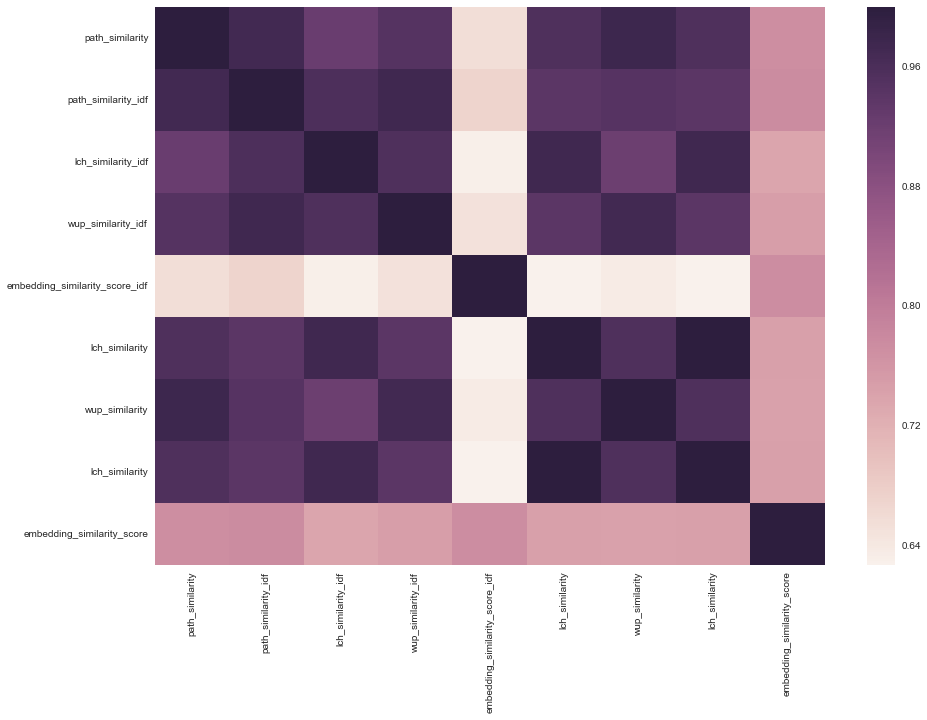

In [46]:
corr = data[[u'path_similarity',
       u'path_similarity_idf', u'lch_similarity_idf', u'wup_similarity_idf',
       u'embedding_similarity_score_idf', u'lch_similarity',
       u'wup_similarity', 'lch_similarity', 'embedding_similarity_score']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [35]:
abridged_features = [u'len_intersection',  u'num_words_q1', u'num_words_q2',
                      u'num_chars_q1', u'num_chars_q2', 
                     u'num_chars_diff', u'partial_ratio', u'partial_ratio_sw', 
                     u'token_set_ratio', u'token_set_ratio_sw', u'partial_token_sort_ratio_sw', 
                      u'wratio_sw', u'word_intersection_tfidf_weight', 
                     u'word_symmetric_difference_tfidf_weight', u'euclidean_distance_sentence_embeddings',
                     u'cosine_distance_sentence_embeddings', u'cityblock_distance_sentence_embeddings', 
                      u'braycurtis_distance_sentence_embeddings', 
                     u'euclidean_distance_max_tfidf_word', u'cosine_distance_max_tfidf_word']

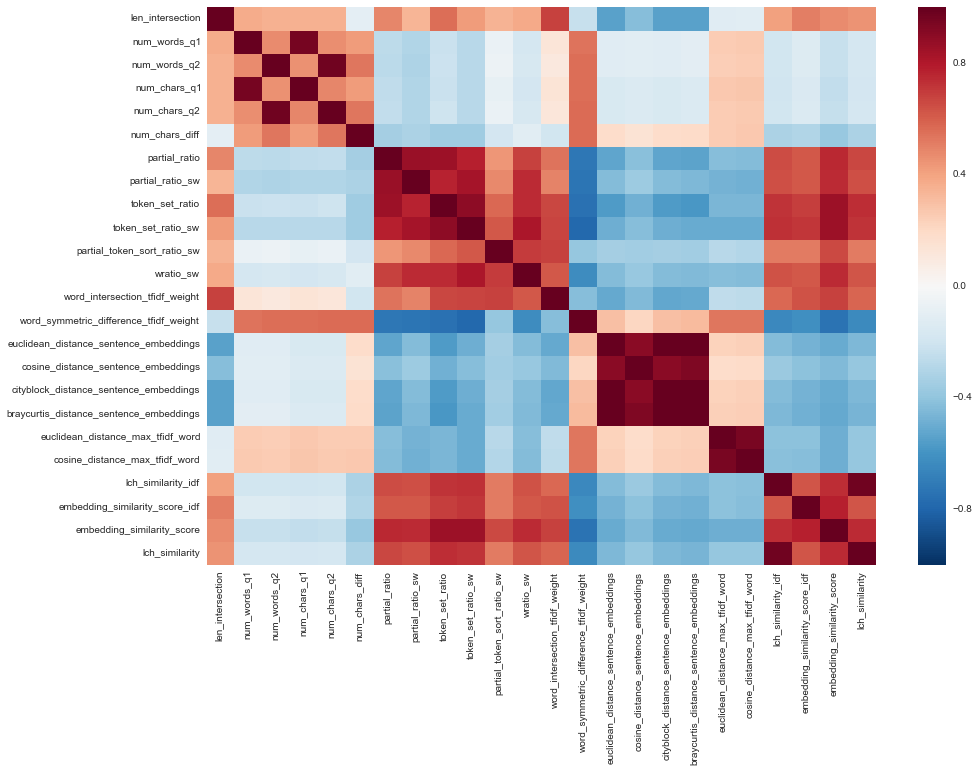

In [47]:
corr = data[abridged_features + ['lch_similarity_idf' , 'embedding_similarity_score_idf', 
                                'embedding_similarity_score', 'lch_similarity']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

#### 6.2 Write Data


In [48]:
data[[col for col in data.columns if col not in [u'q1_embedding', u'q2_embedding']]].to_csv("../data/features.csv")

In [49]:
data.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'id', u'qid1', u'qid2', u'question1',
       u'question2', u'is_duplicate', u'len_intersection',
       u'len_intersection_sw', u'num_words_q1', u'num_words_q1_sw',
       u'num_words_q2', u'num_words_q2_sw', u'num_words_diff',
       u'num_words_diff_sw', u'num_chars_q1', u'num_chars_q1_sw',
       u'num_chars_q2', u'num_chars_q2_sw', u'num_chars_diff',
       u'num_chars_diff_sw', u'partial_ratio', u'partial_ratio_sw',
       u'partial_token_set_ratio', u'partial_token_set_ratio_sw',
       u'token_set_ratio', u'token_set_ratio_sw', u'partial_token_sort_ratio',
       u'partial_token_sort_ratio_sw', u'wratio', u'wratio_sw',
       u'word_intersection_tfidf_weight',
       u'word_symmetric_difference_tfidf_weight',
       u'euclidean_distance_sentence_embeddings',
       u'cosine_distance_sentence_embeddings',
       u'cityblock_distance_sentence_embeddings',
       u'jaccard_distance_sentence_embeddings',
       u'braycurtis_distance_sentence_e